<a href="https://colab.research.google.com/github/ray-hu/EM-Segmentation/blob/master/U_Net_EM_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

### **Install Pytorch**

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/cu80/torch-0.2.0.post2-cp36-cp36m-manylinux1_x86_64.whl torchvision # http://download.pytorch.org/whl/{accelerator}/torch-0.2.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.2.0_2
True


### **Upgrading Tensorflow**

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow

# For the latest nightly build:
#!pip install tf-nightly

### **Import Keras**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [14]:
!pip install Keras

    100% |████████████████████████████████| 317kB 5.5MB/s 


In [17]:
import keras
print(keras.__version__)

2.2.4


### **Import other libraries**

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image
# Restart then PIL will have no error

### **Mounting Google Drive locally**

In [0]:
from google.colab import drive
drive.mount('./GoogleDrive')

In [0]:
#!rm drive

In [0]:
! ln -s GoogleDrive/My\ Drive ./drive

In [0]:
! ls

In [0]:
! ls drive/EM/train-volume.tif

# **Data Augmentation**

In [0]:
import os
import glob
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img

In [70]:
train_imgs_path = glob.glob("drive/data/train"+"/*."+"tif")
label_imgs_path = glob.glob("drive/data/label"+"/*."+"tif")
test_imgs_path = glob.glob("drive/data/test"+"/*."+"tif")

print("We have {} training images in total.".format(len(train_imgs_path)))
print("We have {} training labels in total.".format(len(label_imgs_path)))
print("We have {} testing images in total.".format(len(test_imgs_path)))
if len(train_imgs_path) != len(label_imgs_path) or len(train_imgs_path) == 0:
        print ("num of trains can't match num of labels")

We have 30 training images in total.
We have 30 training labels in total.
We have 30 testing images in total.


Showing the orginal data:


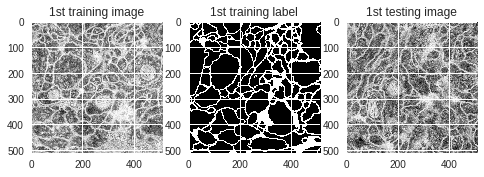

In [59]:
# show the original images
print('Showing the orginal data:')
from skimage import io
image_train = io.imread(train_imgs_path[0])
label_train = io.imread(label_imgs_path[0])
image_test = io.imread(test_imgs_path[0])
f, ax = plt.subplots(1,3)
ax[0].imshow(image_train)
ax[0].set_title('1st training image')
ax[1].imshow(label_train)
ax[1].set_title('1st training label')
ax[2].imshow(image_test)
ax[2].set_title('1st testing image')
plt.show()

In [0]:
# creat folder for the augmentation
path_aug = "drive/data/aug"
if not os.path.lexists(path_aug):
  os.mkdir(path_aug)
savedir = path_aug + "/train"
if not os.path.lexists(savedir):
  os.mkdir(savedir)
savedir = path_aug + "/label"
if not os.path.lexists(savedir):
  os.mkdir(savedir)

In [0]:
def data_augmentation(path_aug='drive/data/aug'):
    
	#read images
    train_path="drive/data/train"
    label_path="drive/data/label"
    img_type="tif"
    train_imgs = glob.glob(train_path+"/*."+img_type)
    label_imgs = glob.glob(label_path+"/*."+img_type)
    slices = len(train_imgs)
    
   # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(rotation_range=10,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=True,fill_mode='constant',cval=0)
	# merge label and train
    print('Using real-time data augmentation.')
    #one by one augmentation
    for i in range(slices):
        img_t = load_img(train_path+"/"+str(i)+".tif",grayscale=True)
        img_l = load_img(label_path+"/"+str(i)+".tif",grayscale=True)
        x_t = img_to_array(img_t)
        x_l = img_to_array(img_l)
        s=np.shape(x_t)
        img = np.ndarray(shape=(s[0],s[1],3),dtype=np.uint8)
      
        img[:,:,0]=x_t[:,:,0]
        img[:,:,2]=x_l[:,:,0]
        	# here's a more "manual" example
        img = img.reshape((1,) + img.shape)
        batches = 0
        for batch in datagen.flow(img, batch_size=1,save_to_dir=path_aug,save_prefix=str(i),save_format='tif'):
            batches += 1
            if batches >= 30:
                break
            # we need to break the loop by hand because
            # the generator loops indefinitely
    aug_imgs = glob.glob(path_aug+"/*.tif")
    savedir = path_aug + "/train"
    if not os.path.lexists(savedir):
        os.mkdir(savedir)
    savedir = path_aug + "/label"
    if not os.path.lexists(savedir):
        os.mkdir(savedir)
    i=0
    for imgname in aug_imgs:
        img =load_img(imgname)
        img=img_to_array(img)
       
        img_train = img[:,:,:1]
        img_label = img[:,:,2:]
        img_train = array_to_img(img_train)
        img_label = array_to_img(img_label)
        img_train.save(path_aug+"/train/"+str(i)+".tif")
        img_label.save(path_aug+"/label/"+str(i)+".tif")
        i+=1

In [87]:
data_augmentation()

Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# Build a U-net

In [0]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch import autograd
from torch.autograd import Variable
dtype = torch.FloatTensor

# two common functions
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        self.conv1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        # 逆卷积，也可以使用上采样
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, 2, 1)
        self.conv11 = nn.Conv2d(2,1,1)
        
        

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        c11 = self.conv11(c10)
        out = nn.Sigmoid()(c11)
        return out

# Training

### Load data

In [0]:
import numpy as np
from skimage import io

image_train = io.imread('drive/EM/train-volume.tif')
label_train = io.imread('drive/EM/train-labels.tif')

imgs_train = image_train[:,np.newaxis,...]
groundTruth_train = label_train[:,np.newaxis,...]

### Train U-net

In [0]:
def sampling_data_aug(imgs_train, label_train):
  # split for training and validation
  imgs_train = imgs_train/255.
  label_train = label_train/255.
  dataset_train = [(img, mask) for img, mask in zip(imgs, masks)]
  shuffle(dataset_train)
  dataset_train_split = dataset_train[0:int(len(dataset_train)*0.8)]
  dataset_valid_split = dataset_train[int(len(dataset_train)*0.8):]
  return dataset_train_split, dataset_valid_split

def training_batch_generator(dataset,batch_size=4):
  # generate batches
  shuffle(dataset)
  N_full_batches = int(np.ceil(len(dataset) / batch_size))
  for i in range(N_full_batches):
    idx_from = batch_size * i
    idx_to = batch_size * (i + 1)
    if idx_to>len(dataset):
      idx_to=len(dataset)
    imgs, masks = zip(*[(img, mask) for img, mask in dataset[idx_from:idx_to]])
    yield imgs, masks
        
def train(net, imgs_train, label_train, n_epoch=10, batch_size=4):

  optimizer = optim.Adam(net.parameters(), lr=1e-4, 
                         betas=(0.9, 0.999), eps=1e-05)
  criterion = nn.BCELoss()
  img_size = 512 ###############
  for epoch in range(n_epoch):
    begin = time.time()
    total_loss_train = 0
    dataset_train_split, dataset_valid_split= sampling_data_aug(imgs_train, label_train)
    bgen = training_batch_generator(dataset_train_split, batch_size=batch_size)
    net.train()
    for idx, (imgs, masks) in enumerate(bgen):
      imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
      masks = np.asarray(masks).reshape(len(masks), 1, img_size, img_size)
      # print(imgs.shape)
      inputs = Variable(torch.from_numpy(imgs).type(dtype))
      targets = Variable(torch.from_numpy(masks).type(dtype))

      optimizer.zero_grad()
      pred = net(inputs)

      loss = criterion(pred, targets)
      loss.backward()

      optimizer.step()

      current_loss = loss.data[0]
      total_loss_train += current_loss
  print('epoch {} -- training loss {}'.format(epoch, total_loss_train/len(dataset_train_split)))
  print('--------------------')
  torch.save(net.state_dict(), 'drive/EM/u-net-em-1/params-{}-{}.pkl'.format(epoch, total_loss_train))
  print("Checkpoint saved")
  print('---------------------------------------------')

In [0]:
! mkdir drive/EM/u-net-em-1

In [0]:
 # load training data
import numpy as np
from skimage import io
image_train = io.imread('drive/EM/train-volume.tif')
label_train = io.imread('drive/EM/train-labels.tif')
image_test = io.imread('drive/EM/test-volume.tif')
imgs_train = image_train[:,np.newaxis,...]
groundTruth_train = label_train[:,np.newaxis,...]
imgs_test = image_test[:,np.newaxis,...]

In [0]:
net = Unet()
train(net, imgs_train, groundTruth_train, n_epoch=10, batch_size=4)

# Test

### Load test data and trained model

In [0]:
import numpy as np
from skimage import io
image_test = io.imread('drive/EM/test-volume.tif')
imgs_test = image_test[:,np.newaxis,...]/225.

In [0]:
! ls drive/EM/u-net-em-1

params-10-3.885419975966215.pkl  params-1-4.966989494860172.pkl
params-12-3.679324809461832.pkl  params-5-4.025522708892822.pkl
params-13-3.782213229686022.pkl


In [0]:
net = Unet()
net.load_state_dict(torch.load('drive/EM/u-net-em-1/params-13-3.782213229686022.pkl'))

In [0]:
def test(net, imgs):
  net.eval()
  img_size = 512
  imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
  pred = net(imgs)
  return pred
    

In [0]:
pred.shape

(30, 1, 512, 512)

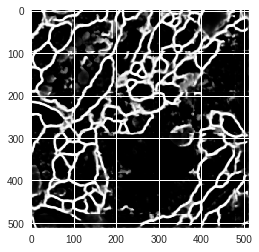

In [0]:
plt.imshow(pred[0][0])

In [0]:
results = np.squeeze(pred)
results = results.astype(np.float16)
io.imsave('drive/data/results.tif', results)

In [0]:
results = results.astype(np.float16)

In [0]:
io.imsave('drive/data/results.tif', results)